## Business Use Case

Nestlé’s HR department manages extensive policy documentation, which employees often need to access for quick clarifications on topics such as leave rules, benefits, compliance, and workplace guidelines.  

This **RAG-based HR Policy Chatbot** enables employees to:
- Ask **natural language questions** about HR policies.
- Receive **instant, context-aware answers** sourced from official PDF documents.
- Reduce dependency on HR staff for routine queries.
- Ensure consistent and **accurate information retrieval**.

By integrating **local embeddings**, **FAISS indexing**, and **Groq-powered generation**, the chatbot streamlines policy access, improves productivity, and enhances employee experience.


hr_rag_architecture.svg

# Nestlé HR Policy RAG Chatbot (Gradio + Groq)

## Overview  
This chatbot implements the following **Solution Approach**:  
1. **Load & chunk** Nestlé HR PDFs  
2. **Embed chunks** using *Sentence-Transformers*  
3. **Index** in FAISS  
4. **Retrieve** relevant chunks for a query  
5. **Generate answer** with Groq GPT-style chat completion using retrieved context  
6. **Serve** a Gradio chat UI with streaming  

---

## Setup

```bash
pip install -r requirements.txt


In [10]:
! pip install -q gradio>=4.0.0 groq>=0.9.0 gradio>=4.0.0 faiss-cpu>=1.8.0 sentence-transformers>=3.0.0 pypdf>=4.2.0

In [ ]:
GROQ_API_KEY="YOUR_GROQ_KEY"

In [ ]:
import os
# Replace "YOUR_API_KEY" with your actual Groq API key
#os.environ["GROQ_API_KEY"] = "YOUR_API_KEY"
os.environ["GROQ_API_KEY"] = "get your own key"

In [6]:
GROQ_API_KEY="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"

In [ ]:
import os
import io
import json
import faiss
import time
import pickle
import gradio as gr
from dataclasses import dataclass
from typing import List, Tuple, Dict

# PDF/text & embeddings
from pypdf import PdfReader
from sentence_transformers import SentenceTransformer
from groq import Groq
from pathlib import Path

In [23]:
# ------------ Config ------------
DOCS_DIR = os.getenv("DOCS_DIR", "/content")
INDEX_DIR = os.getenv("INDEX_DIR", "./faiss_index")
EMBED_MODEL_NAME = os.getenv("EMBED_MODEL", "all-MiniLM-L6-v2")
DEFAULT_MODEL = os.getenv("GROQ_DEFAULT_MODEL", "openai/gpt-oss-120b")
AVAILABLE_MODELS = [
    "openai/gpt-oss-120b",
    "llama-3.1-70b-versatile",
    "llama-3.1-8b-instant",
    "mixtral-8x7b-32768",
    "gemma2-9b-it",
]

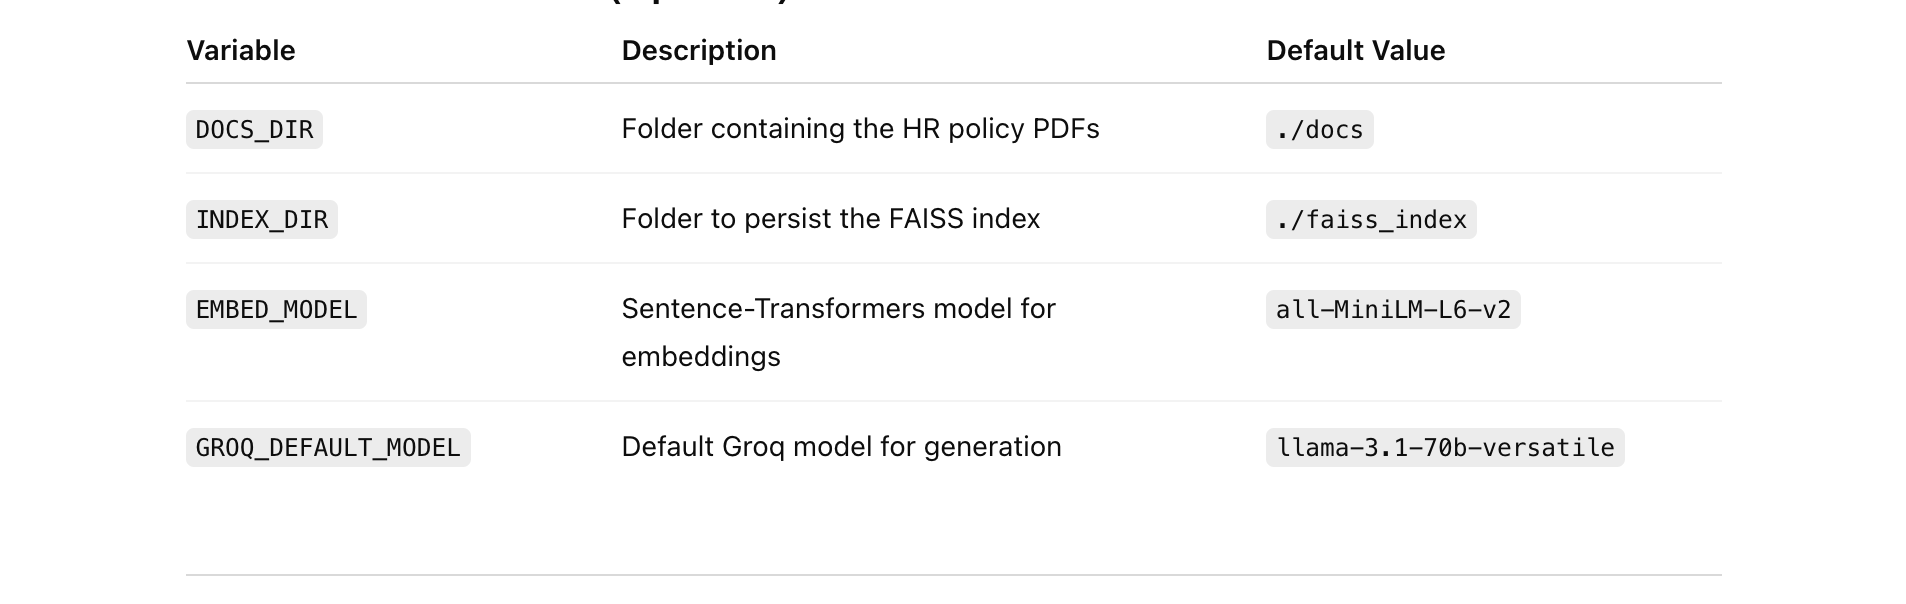

In [24]:
SYSTEM_PROMPT_DEFAULT = (
    "You are an HR policy assistant. Answer using ONLY the provided context. "
    "If the answer is not in the context, say you don't know. Be concise."
)

In [25]:
# Chunking params
CHUNK_SIZE = 1000
CHUNK_OVERLAP = 200
TOP_K = 4

Path(DOCS_DIR).mkdir(parents=True, exist_ok=True)
Path(INDEX_DIR).mkdir(parents=True, exist_ok=True)

In [26]:
# ------------ Utilities ------------
@dataclass
class DocChunk:
    text: str
    source: str
    page: int
    chunk_id: int


def read_pdfs(folder: str) -> List[Tuple[str, int, str]]:
    """
    Return list of (source_path, page_num (1-based), page_text)
    """
    out = []
    for p in sorted(Path(folder).glob("*.pdf")):
        try:
            reader = PdfReader(str(p))
            for i, page in enumerate(reader.pages, start=1):
                text = page.extract_text() or ""
                text = text.strip()
                if text:
                    out.append((str(p), i, text))
        except Exception as e:
            print(f"[WARN] Failed to read {p}: {e}")
    return out


def chunk_text(text: str, size: int = CHUNK_SIZE, overlap: int = CHUNK_OVERLAP) -> List[str]:
    """
    Simple character-based chunking with overlap.
    """
    if not text:
        return []
    chunks = []
    start = 0
    n = len(text)
    while start < n:
        end = min(start + size, n)
        chunk = text[start:end]
        chunks.append(chunk)
        if end == n:
            break
        start = end - overlap
        if start < 0:
            start = 0
    return chunks


def build_corpus(pages: List[Tuple[str, int, str]]) -> List[DocChunk]:
    """
    From list of pages, produce chunk objects with metadata.
    """
    corpus = []
    cid = 0
    for source, page_num, txt in pages:
        for piece in chunk_text(txt):
            corpus.append(DocChunk(text=piece, source=source, page=page_num, chunk_id=cid))
            cid += 1
    return corpus


def ensure_index(corpus: List[DocChunk], embed_model_name: str, index_dir: str):
    """
    Build or load FAISS index. Returns (index, id_to_meta)
    """
    meta_path = Path(index_dir) / "meta.pkl"
    faiss_path = Path(index_dir) / "index.faiss"

    if meta_path.exists() and faiss_path.exists():
        # Load existing
        with open(meta_path, "rb") as f:
            id_to_meta = pickle.load(f)
        index = faiss.read_index(str(faiss_path))
        print(f"[Index] Loaded index from {faiss_path} and metadata from {meta_path}")
        return index, id_to_meta

    # Build new
    embedder = SentenceTransformer(embed_model_name)
    embedding_dim = embedder.get_sentence_embedding_dimension()

    texts = [c.text for c in corpus]
    print(f"[Index] Computing embeddings for {len(texts)} chunks with {embed_model_name}...")
    vectors = embedder.encode(texts, show_progress_bar=True, normalize_embeddings=True)
    index = faiss.IndexFlatIP(embedding_dim)  # cosine (since normalized)
    index.add(vectors)

    id_to_meta = {i: {"text": corpus[i].text, "source": corpus[i].source, "page": corpus[i].page} for i in range(len(corpus))}

    # Persist
    faiss.write_index(index, str(faiss_path))
    with open(meta_path, "wb") as f:
        pickle.dump(id_to_meta, f)

    print(f"[Index] Saved index to {faiss_path} and metadata to {meta_path}")
    return index, id_to_meta


def retrieve(query: str, index, id_to_meta: Dict[int, Dict], embedder, k: int = TOP_K) -> List[Dict]:
    qvec = embedder.encode([query], normalize_embeddings=True)
    D, I = index.search(qvec, k)
    hits = []
    for rank, idx in enumerate(I[0]):
        if idx == -1:
            continue
        meta = id_to_meta.get(int(idx), {})
        meta = dict(meta)
        meta["score"] = float(D[0][rank])
        hits.append(meta)
    return hits


def get_client():
    #api_key = os.getenv("GROQ_API_KEY")
    api_key = "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"
    if not api_key:
        raise RuntimeError("GROQ_API_KEY not set. export GROQ_API_KEY='your_key'")
    return Groq(api_key=api_key)


def stream_answer(user_query: str,
                  system_prompt: str,
                  model_name: str,
                  temperature: float,
                  max_tokens: int,
                  top_p: float,
                  index,
                  id_to_meta):
    user_query = (user_query or "").strip()
    if not user_query:
        yield "Please enter a question about the HR policy."
        return

    # Initialize embedder here
    embedder = SentenceTransformer(EMBED_MODEL_NAME)

    # Retrieve
    hits = retrieve(user_query, index, id_to_meta, embedder, k=TOP_K)
    context_blocks = []
    citations = []
    for h in hits:
        context_blocks.append(h["text"])
        citations.append(f"[p.{h['page']}] {Path(h['source']).name}")
    context = "\n\n---\n\n".join(context_blocks)
    cite_line = " | ".join(citations)

    # Compose prompt
    prompt = (
        f"Context from Nestlé HR policy (use only this to answer):\n\n{context}\n\n"
        f"Citations: {cite_line}\n\n"
        f"Question: {user_query}\n\n"
        f"Instructions: If the answer is not contained in the context, say you don't know."
    )

    client = get_client()

    try:
        stream = client.chat.completions.create(
            model=model_name,
            messages=[
                {"role": "system", "content": system_prompt.strip() or SYSTEM_PROMPT_DEFAULT},
                {"role": "user", "content": prompt},
            ],
            temperature=float(temperature),
            max_tokens=int(max_tokens),
            top_p=float(top_p),
            stream=True,
        )
    except Exception as e:
        yield f"❌ Error creating completion: {e}"
        return

    collected = []
    header = f"🔎 Sources: {cite_line}\n\n"
    collected.append(header)
    yield "".join(collected)

    try:
        for chunk in stream:
            delta = chunk.choices[0].delta.content or ""
            if delta:
                collected.append(delta)
                yield "".join(collected)
    except Exception as e:
        yield "".join(collected) + f"\n\n❌ Streaming stopped due to error: {e}"


def bootstrap_index():
    pages = read_pdfs(DOCS_DIR)
    if not pages:
        print(f"[WARN] No PDFs found in {DOCS_DIR}. Place Nestlé HR PDFs there and restart.")
        # Return empty index and metadata if no PDFs are found
        return None, {}
    corpus = build_corpus(pages)
    index, id_to_meta = ensure_index(corpus, EMBED_MODEL_NAME, INDEX_DIR)
    return index, id_to_meta


def build_demo(index, id_to_meta):
    with gr.Blocks(title="Nestlé HR RAG • Groq + Gradio") as demo:
        gr.Markdown("# 🧭 Nestlé HR Assistant (RAG + Groq)\nAsk questions on the HR policy PDFs.")

        with gr.Row():
            system_prompt = gr.Textbox(
                label="System Prompt",
                value=SYSTEM_PROMPT_DEFAULT,
                lines=3,
            )

        with gr.Row():
            model_dd = gr.Dropdown(
                choices=AVAILABLE_MODELS,
                value=DEFAULT_MODEL if DEFAULT_MODEL in AVAILABLE_MODELS else AVAILABLE_MODELS[0],
                label="Groq Model",
            )
            temperature = gr.Slider(0.0, 1.5, value=0.4, step=0.05, label="Temperature")
            max_tokens = gr.Slider(64, 4096, value=512, step=64, label="Max tokens")
            top_p = gr.Slider(0.1, 1.0, value=1.0, step=0.05, label="Top-p")

        with gr.Row():
            user_query = gr.Textbox(
                label="Your Question",
                placeholder="e.g., What is Nestlé's policy on Total Rewards?",
                lines=4,
            )

        output = gr.Textbox(label="Answer (with streaming & sources)", lines=18)
        run_btn = gr.Button("Ask", variant="primary")

        # Wire streaming
        run_btn.click(
            fn=stream_answer,
            inputs=[user_query, system_prompt, model_dd, temperature, max_tokens, top_p,
                    gr.State(index), gr.State(id_to_meta)],
            outputs=output,
        )

        with gr.Accordion("Index status / How to add PDFs", open=False):
            gr.Markdown(
                f"- Documents folder: `{DOCS_DIR}`\n"
                f"- Index folder: `{INDEX_DIR}`\n"
                f"- Embed model: `{EMBED_MODEL_NAME}`\n\n"
                "To add more PDFs, drop them into the docs folder and restart the app to rebuild/load the index."
            )

    return demo


def main():
    index, id_to_meta = bootstrap_index()
    if index is None or not id_to_meta:
        print("Index creation failed or no documents found. Exiting.")
        return
    demo = build_demo(index, id_to_meta)
    demo.queue().launch()


if __name__ == "__main__":
    main()

[Index] Loaded index from faiss_index/index.faiss and metadata from faiss_index/meta.pkl
It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://9a29e7fdd72e42e267.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [13]:
pwd

'/content'

hr_rag_architecture (1).svg